# Brain Tumor Detector

## Get and Load Dataset

In [91]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers, models
from tensorflow import keras

In [92]:
!pip install --upgrade --no-cache-dir gdowna

ERROR: Could not find a version that satisfies the requirement gdowna (from versions: none)
ERROR: No matching distribution found for gdowna


In [93]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=421cdb0d-7aab-455b-a417-eecebfbbb753
To: /content/brain_tumor.zip
100% 156M/156M [00:00<00:00, 236MB/s]


In [94]:
!unzip -q brain_tumor.zip

replace Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [95]:
ls -l

total 152152
-rw-r--r-- 1 root root 155791278 Apr  4 11:17 brain_tumor.zip
drwxr-xr-x 1 root root      4096 Apr  2 13:23 sample_data/
drwxr-xr-x 6 root root      4096 Apr  4 08:00 Testing/
drwxr-xr-x 6 root root      4096 Apr  4 08:00 Training/


In [96]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [97]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures, run only on linux systems like colab

./Training/
├── glioma  [1321 entries exceeds filelimit, not opening dir]
├── meningioma  [1339 entries exceeds filelimit, not opening dir]
├── notumor  [1595 entries exceeds filelimit, not opening dir]
└── pituitary  [1457 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [98]:
!tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures, run only on linux systems like colab

./Testing/
├── glioma  [300 entries exceeds filelimit, not opening dir]
├── meningioma  [306 entries exceeds filelimit, not opening dir]
├── notumor  [405 entries exceeds filelimit, not opening dir]
└── pituitary  [300 entries exceeds filelimit, not opening dir]

4 directories, 0 files


## Load Dependencies

In [99]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.15.0


## Utility functions to create dataset generators

In [112]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions


### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [101]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


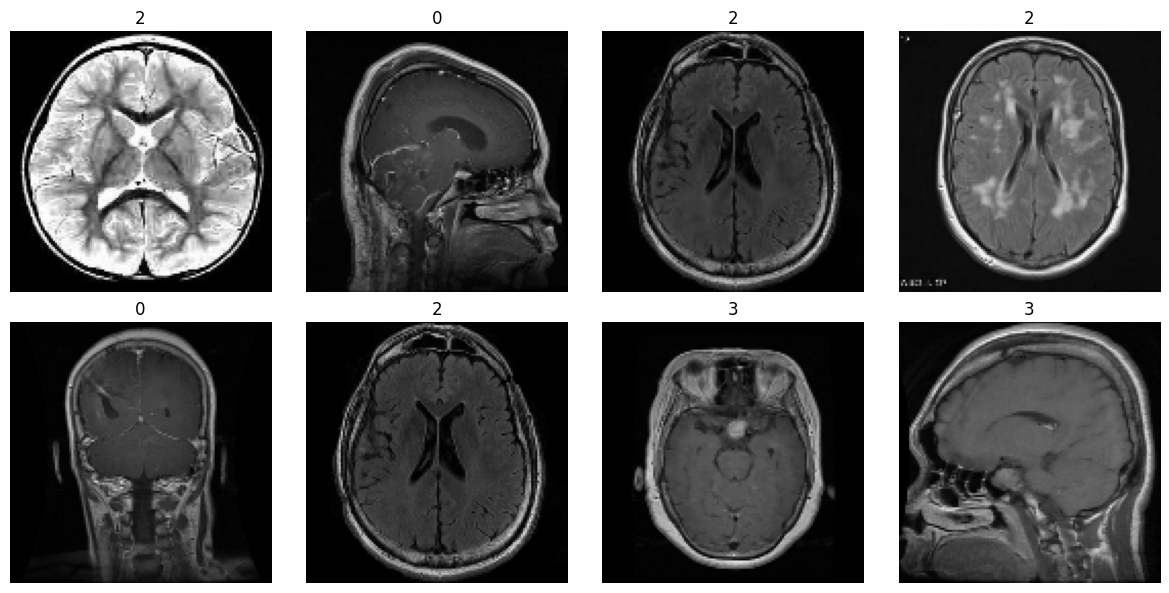

In [102]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__

In [103]:
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

In [104]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [105]:
print(len(train_ds))

143


In [109]:
# here comes the model


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [88]:
# Load the training and validation datasets
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [ ]:
# andere lösung

In [82]:
y_true, y_pred = eval_model_on_test(model)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:12,  1.22s/it]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:05,  1.73it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.67it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:02,  3.47it/s]

4/4 [==============================] - 2s 637ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:04<00:06,  1.14s/it]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:04<00:04,  1.10it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:05<00:02,  1.40it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:06<00:01,  1.30it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:06<00:00,  1.67it/s]

1/1 [==============================] - 0s 480ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


In [ ]:
# basic solution

In [139]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

IMG_DIMS = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 30

In [113]:



def prepare_data():
    train_ds, val_ds = prepare_train_val_dataset()
    return train_ds, val_ds

def prepare_train_val_dataset():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    return train_ds, val_ds

def create_model():
    model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=IMG_SHAPE),
        MaxPooling2D(),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),

        Flatten(),
        Dense(NUM_CLASSES) # Output layer has size equal to the number of classes
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

def train_model():
    train_ds, val_ds = prepare_data()
    model = create_model()
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

if __name__ == "__main__":
    train_model()


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Epoch 1/10
143/143 [==============================] - 9s 51ms/step - loss: 8.4904 - accuracy: 0.7037 - val_loss: 0.5396 - val_accuracy: 0.8100
Epoch 2/10
143/143 [==============================] - 6s 41ms/step - loss: 0.2648 - accuracy: 0.9127 - val_loss: 0.3467 - val_accuracy: 0.8967
Epoch 3/10
143/143 [==============================] - 7s 47ms/step - loss: 0.1132 - accuracy: 0.9702 - val_loss: 0.3536 - val_accuracy: 0.8975
Epoch 4/10
143/143 [==============================] - 6s 42ms/step - loss: 0.0472 - accuracy: 0.9893 - val_loss: 0.3892 - val_accuracy: 0.9011
Epoch 5/10
143/143 [==============================] - 7s 48ms/step - loss: 0.0301 - accuracy: 0.9930 - val_loss: 0.4587 - val_accuracy: 0.9081
Epoch 6/10
143/143 [==============================] - 6s 41ms/step - loss: 0.0154 - accuracy: 0.9967 - val_loss: 0.4160 - val_accuracy: 0.9

In [157]:
#resnet model
def create_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    base_model.trainable = False # Freeze the base model by not training it

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dense(NUM_CLASSES, activation='softmax') # Output layer has size equal to the number of classes
    ])

   # Compile the model
        model.compile(optimizer=Adam(),
        loss=categorical_crossentropy,
         metrics=['accuracy'])
    return model

In [158]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_23 (Dense)            (None, 4)                

In [ ]:
def train_model():
    train_ds, val_ds = prepare_data()
    model = create_model()
    history1 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

if __name__ == "__main__":
    train_model()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


142/143 [============================>.] - ETA: 0s - loss: 0.6706 - accuracy: 0.8107

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


143/143 [==============================] - 13s 68ms/step - loss: 0.6681 - accuracy: 0.8109 - val_loss: 0.2629 - val_accuracy: 0.8975
Epoch 2/30
143/143 [==============================] - 9s 63ms/step - loss: 0.2387 - accuracy: 0.9077 - val_loss: 0.2758 - val_accuracy: 0.9054
Epoch 3/30
143/143 [==============================] - 8s 56ms/step - loss: 0.1941 - accuracy: 0.9260 - val_loss: 0.3084 - val_accuracy: 0.8984
Epoch 4/30
143/143 [==============================] - 9s 60ms/step - loss: 0.1404 - accuracy: 0.9462 - val_loss: 0.2443 - val_accuracy: 0.9168
Epoch 5/30
143/143 [==============================] - 9s 59ms/step - loss: 0.1032 - accuracy: 0.9635 - val_loss: 0.1995 - val_accuracy: 0.9308
Epoch 6/30
143/143 [==============================] - 8s 53ms/step - loss: 0.0779 - accuracy: 0.9722 - val_loss: 0.2090 - val_accuracy: 0.9299
Epoch 7/30
143/143 [==============================] - 9s 59ms/step - loss: 0.0742 - accuracy: 0.9722 - val_loss: 0.2008 - val_accuracy: 0.9317
Epoch 8/3

In [156]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_23 (Dense)            (None, 4)                

In [147]:
# results
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [148]:
y_true, y_pred = eval_model_on_test(model)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:13,  1.37s/it]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:03,  2.45it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:02,  3.36it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.03it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:02<00:01,  4.56it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:02<00:01,  3.95it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  4.71it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  5.18it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]


In [149]:
y_pred_class = np.argmax(y_pred,1)

In [150]:
y_pred_class.shape

(1311,)

In [151]:
class_names=['glioma', 'meningioma', 'notumor', 'pituitary']

In [153]:
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

AttributeError: 'History' object has no attribute 'history1'

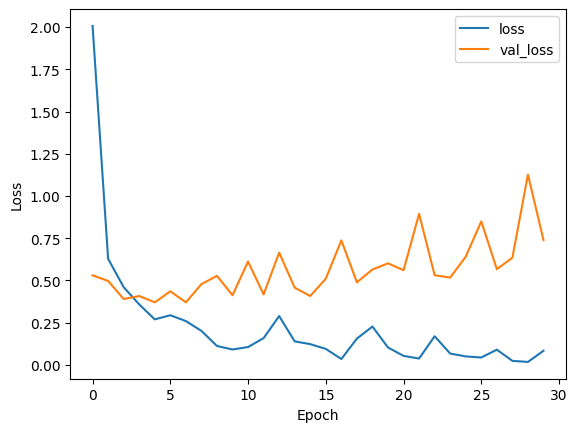

In [134]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right');

In [154]:
print(classification_report(y_true, y_pred_class, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.20      0.12      0.15       300
  meningioma       0.28      0.55      0.37       306
     notumor       0.23      0.26      0.25       405
   pituitary       0.04      0.01      0.02       300

    accuracy                           0.24      1311
   macro avg       0.19      0.24      0.20      1311
weighted avg       0.19      0.24      0.20      1311



In [155]:
y_pred[0]

array([-13.821668,  -4.973882,  -9.779135,  -2.78432 ], dtype=float32)